# Use Case 6: Comparing Derived Molecular Data with Proteomics


For this use case, we will be looking at the derived molecular data contained in the Endometrial dataset, and comparing it with protein data. Derived molecular data means that we created new variables based on molecular data. One example of this is the activity of a pathway based on the abundance of phosphorylation sites. A second example is inferred cell type percentages from algorithms like CIBERSORT, which are based on comparing transcriptomics data to known profiles of pure cell types. 

## Step 1: Importing packages

We will start by importing the python packages we will need, including the cptac data package. We will then load the Endometrial dataset which includes the endometrial patient data as well as accessory functions that we will use to analyze the data.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cptac
en = cptac.Endometrial()

## Step 2: Getting data and selecting attributes

For this use case, we will be using two dataframes contained in the Endometrial dataset: <code>derived_molecular</code> and <code>proteomics</code>. We will load the derived_molecular dataframe and examine the data contained within it.

In [2]:
der_molecular = en.get_derived_molecular()

The derived molecular dataframe contains many different attributes that we can choose from for analysis. To view a list of these attributes, we can print out the column names of the dataframe. To view the full list of column names without truncation, first use the command <code>pd.set_option('display.max_seq_items', None)</code>.


In [3]:
der_molecular.columns.tolist()

['Estrogen_Receptor',
 'Estrogen_Receptor_%',
 'Progesterone_Receptor',
 'Progesterone_Receptor_%',
 'MLH1',
 'MLH2',
 'MSH6',
 'PMS2',
 'p53',
 'Other_IHC_specify',
 'MLH1_Promoter_Hypermethylation',
 'EPIC_Bcells',
 'EPIC_CAFs',
 'EPIC_CD4_Tcells',
 'EPIC_CD8_Tcells',
 'EPIC_Endothelial',
 'EPIC_Macrophages',
 'EPIC_NKcells',
 'EPIC_otherCells',
 'CIBERSORT_B _cells _naive',
 'CIBERSORT_B _cells _memory',
 'CIBERSORT_Plasma _cells',
 'CIBERSORT_T _cells _CD8',
 'CIBERSORT_T _cells _CD4 _naive',
 'CIBERSORT_T _cells _CD4 _memory _resting',
 'CIBERSORT_T _cells _CD4 _memory _activated',
 'CIBERSORT_T _cells _follicular _helper',
 'CIBERSORT_T _cells _regulatory _(Tregs)',
 'CIBERSORT_T _cells _gamma _delta',
 'CIBERSORT_NK _cells _resting',
 'CIBERSORT_NK _cells _activated',
 'CIBERSORT_Monocytes',
 'CIBERSORT_Macrophages _M0',
 'CIBERSORT_Macrophages _M1',
 'CIBERSORT_Macrophages _M2',
 'CIBERSORT_Dendritic _cells _resting',
 'CIBERSORT_Dendritic _cells _activated',
 'CIBERSORT_Mast _

For this use case, we will compare MSI status with the JAK1 protein abundance. MSI stands for <a href="https://en.wikipedia.org/wiki/Microsatellite_instability">Microsatellite instability</a>. The possible values for MSI status are MSI-H (high microsatellite instability) or MSS (microsatellite stable). In this context, "nan" refers to non-tumor samples. To see all of the possible values in any column, you can use the pandas function <code>.unique()</code>

In [4]:
der_molecular['MSI_status'].unique()

array(['MSI-H', 'MSS', nan], dtype=object)

## Step 3: Merge dataframes

We will use the <code>en.append_metadada_to_omics</code> function to merge our desired molecular trait with the proteomics data.  

In [5]:
merged_data = en.append_metadata_to_omics(metadata_df_name="derived_molecular", omics_df_name="proteomics", metadata_cols='MSI_status')

## Step 4: Plot data

Now we will use the seaborn and matplotlib libraries to create a boxplot and histogram that will allow us to visualize this data. For more information on using seaborn, see this <a href="https://seaborn.pydata.org/tutorial.html">seaborn tutorial</a>.

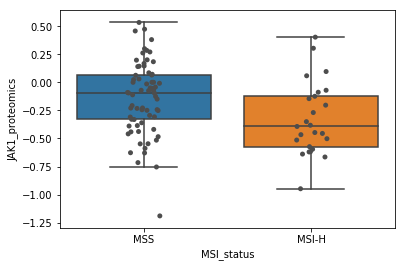

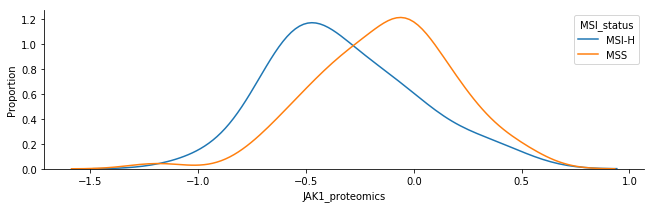

In [6]:
msi_boxplot = sns.boxplot(x='MSI_status', y='JAK1_proteomics', data = merged_data, showfliers = False, order = ['MSS', 'MSI-H'])
msi_boxplot = sns.stripplot(x='MSI_status', y='JAK1_proteomics', data = merged_data, color = '.3', order = ['MSS', 'MSI-H'])
plt.show()

msi_histogram = sns.FacetGrid(merged_data[['MSI_status', 'JAK1_proteomics']], hue="MSI_status", legend_out=False, aspect = 3)
msi_histogram = msi_histogram.map(sns.kdeplot, "JAK1_proteomics").add_legend(title="MSI_status")
msi_histogram.set(ylabel='Proportion')
plt.show()